In [1]:
# We load the relevant packages

import numpy as np
from numpy import abs, sqrt, log10, sin, cos, exp, cosh, tanh, log, conj, cosh, sinh
np.set_printoptions(precision=16)
from math import pi, factorial
from numpy.random import rand
from numpy.linalg import norm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg, csc_matrix
import time
from scipy.optimize import minimize
from scipy.special import eval_hermite
import pickle

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
#mpl.rcParams["figure.dpi"] = 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from qonn_cobyla import *

In [2]:
N_p_list = np.arange(4, 104, 4) # Number of photons threshold per cavity
point = 4 # Index for the value of N in which we are interested
N_p = N_p_list[point] # Fix the value of N
print('N = {:}'.format(N_p))

# Loss rate list for each type of state
kappa_list_coh = 10**(np.linspace(-2.25, 0, 20)) # For coherent states
kappa_list_tfs = 10**(np.linspace(-2.25, 0, 20)) # For twin Fock states
kappa_list_noon = 10**(np.linspace(-2.25, np.log10(5e-1), 20)) # For NOON states
kappa_list = 10**(np.linspace(-2, 0, 10))

# Interferometer parameters
phi = [0, pi/3, 0] # Encoded phase difference
delta = 1e-2 # To measure QFI
phi_delta = [0, pi/3 + delta, 0]

d = 5 # Number of layers
layers_p = d # For the preparation PQC
layers_m = d # For the measurement PQC

N = 20


### Coherent state

In [3]:
QFI_coh = []
CFI_coh = []

for kappa in kappa_list_coh:

    print('===> kappa = {:}'.format(kappa))

    setup = Setup(2, 2, N_p)
    oc = KerrMeasCircuit(setup, layers_p, layers_m, delta, kappa)

    # We create the coherent state (up to an N_p/2 threshold in each mode)
    alpha = sqrt(N_p/4)
    psi_coh = 0.0
    for n in range(int(N_p/2 + 1)):
        cavity = np.zeros(N_p + 1, dtype=np.complex128)
        cavity[n] = 1.0
        psi_coh += alpha**n/sqrt(float(factorial(n)))*cavity
    psi_coh = exp(-abs(alpha)**2/2) * psi_coh
    psi_coh = psi_coh / sqrt(np.real(psi_coh[np.newaxis, :].conj() @ psi_coh[:, np.newaxis]))[0][0]
    psi = np.kron(psi_coh, psi_coh)

    # Phase encoding
    psi_phi = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi)
    psi_phi = sp.linalg.expm_multiply(-1j * phi[1] * setup.H_phi(), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi_phi)

    psi_delta = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi)
    psi_delta = sp.linalg.expm_multiply(-1j * phi_delta[1] * setup.H_phi(), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi_delta)

    grad_psi = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi)
    grad_psi = sp.linalg.expm_multiply(-1j * phi[1] * setup.H_phi(), grad_psi)
    grad_psi = -1j * setup.H_phi() @ grad_psi
    grad_psi = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), grad_psi)

    # Density matrices
    rho_phi = psi_phi[:, np.newaxis] @ psi_phi[np.newaxis, :].conj()
    rho_delta = psi_delta[:, np.newaxis] @ psi_delta[np.newaxis, :].conj()
    grad_rho = grad_psi[:, np.newaxis] @ psi_phi[np.newaxis, :].conj()
    grad_rho += grad_rho.transpose().conj()

    # Vectorize density matrices
    rho_phi = np.reshape(rho_phi, (len(rho_phi)**2, 1))
    rho_delta = np.reshape(rho_delta, (len(rho_delta)**2, 1))
    grad_rho = np.reshape(grad_rho, (len(grad_rho)**2, 1))

    # Losses
    rho_phi = sp.linalg.expm_multiply(oc.L_ad, rho_phi)
    rho_delta = sp.linalg.expm_multiply(oc.L_ad, rho_delta)
    rho_phi = sp.linalg.expm_multiply(oc.L_pd, rho_phi)
    rho_delta = sp.linalg.expm_multiply(oc.L_pd, rho_delta)
    rho_phi = np.reshape(rho_phi, (int(sqrt(len(rho_phi))), int(sqrt(len(rho_phi)))))
    rho_delta = np.reshape(rho_delta, (int(sqrt(len(rho_delta))), int(sqrt(len(rho_delta))))) 

    grad_rho = sp.linalg.expm_multiply(oc.L_ad, grad_rho)
    grad_rho = sp.linalg.expm_multiply(oc.L_pd, grad_rho)
    grad_rho = np.reshape(grad_rho, (int(sqrt(len(grad_rho))), int(sqrt(len(grad_rho))))) 

    # Evaluate QFI
    F = np.real(np.trace(sqrtm(sqrtm(rho_phi) @ rho_delta @ sqrtm(rho_phi))))
    cost = 8*(1-F)/delta**2
    print(8*(1-F))
    print(delta**2)
    print(cost)

    # Evaluate classical Fisher information
    I = np.sum(1/np.diag(rho_phi + 1e-30) * np.diag(grad_rho)**2)

    QFI_coh.append(cost)
    CFI_coh.append(np.real(I))

===> kappa = 0.005623413251903491
0.0020712613043984973
0.0001
20.712613043984973
===> kappa = 0.007386199822079358
0.0020316586311963647
0.0001
20.316586311963647
===> kappa = 0.009701571868867782
0.0019840494462304292
0.0001
19.840494462304292
===> kappa = 0.012742749857031334
0.001927831112949363
0.0001
19.27831112949363
===> kappa = 0.01673725413919161
0.001862849787908516
0.0001
18.62849787908516
===> kappa = 0.021983926488622893
0.0017895023300678048
0.0001
17.895023300678048
===> kappa = 0.028875287417994458
0.0017086097853127313
0.0001
17.086097853127313
===> kappa = 0.0379269019073225
0.0016213898801886728
0.0001
16.213898801886728
===> kappa = 0.04981595048613269
0.001529441034105794
0.0001
15.29441034105794
===> kappa = 0.06543189129712966
0.001434083569086475
0.0001
14.34083569086475
===> kappa = 0.08594300333406646
0.0013365929942139587
0.0001
13.365929942139587
===> kappa = 0.11288378916846889
0.0012379436985803238
0.0001
12.379436985803238
===> kappa = 0.1482697760456354

### N00N state

In [4]:
QFI_noon = []

for kappa in kappa_list_noon:

    print('kappa = {:}'.format(kappa))

    setup = Setup(2, 2, int(N_p/2))
    oc = KerrMeasCircuit(setup, layers_p, layers_m, delta, kappa)

    # We create the N00N state
    cavity_1 = np.zeros(int(N_p/2) + 1, dtype=np.complex128)
    cavity_1[int(N_p/2)] = 1.0
    cavity_2 = np.zeros(int(N_p/2) + 1, dtype=np.complex128)
    cavity_2[0] = 1.0
    psi_1 = np.kron(cavity_1, cavity_2)
    cavity_1 = np.zeros(int(N_p/2) + 1, dtype=np.complex128)
    cavity_1[0] = 1.0
    cavity_2 = np.zeros(int(N_p/2) + 1, dtype=np.complex128)
    cavity_2[int(N_p/2)] = 1.0
    psi_2 = np.kron(cavity_1, cavity_2)
    psi = (psi_1 + psi_2)/sqrt(2)

    # Phase encoding
    psi_phi = sp.linalg.expm_multiply(-1j * phi[1] * setup.H_phi(), psi)
    psi_phi = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi_phi)

    psi_delta = sp.linalg.expm_multiply(-1j * phi_delta[1] * setup.H_phi(), psi)
    psi_delta = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi_delta)

    # Density matrices
    rho_phi = psi_phi[:, np.newaxis] @ psi_phi[np.newaxis, :].conj()
    rho_delta = psi_delta[:, np.newaxis] @ psi_delta[np.newaxis, :].conj()

    # Vectorize density matrices
    rho_phi = np.reshape(rho_phi, (len(rho_phi)**2, 1))
    rho_delta = np.reshape(rho_delta, (len(rho_delta)**2, 1))

    # Losses
    rho_phi = sp.linalg.expm_multiply(oc.L_ad, rho_phi)
    rho_delta = sp.linalg.expm_multiply(oc.L_ad, rho_delta)
    rho_phi = sp.linalg.expm_multiply(oc.L_pd, rho_phi)
    rho_delta = sp.linalg.expm_multiply(oc.L_pd, rho_delta)
    rho_phi = np.reshape(rho_phi, (int(sqrt(len(rho_phi))), int(sqrt(len(rho_phi)))))
    rho_delta = np.reshape(rho_delta, (int(sqrt(len(rho_delta))), int(sqrt(len(rho_delta))))) 

    # Evaluate QFI
    F = np.real(np.trace(sqrtm(sqrtm(rho_phi) @ rho_delta @ sqrtm(rho_phi))))
    cost = 8*(1-F)/delta**2

    QFI_noon.append(cost)

kappa = 0.005623413251903491
kappa = 0.007121596584456048
kappa = 0.009018924208454467
kappa = 0.01142173568991326
kappa = 0.014464701460507566
kappa = 0.018318370694428023
kappa = 0.023198730081962195
kappa = 0.029379309240610496
kappa = 0.037206511235998434
kappa = 0.047119027442651736
kappa = 0.0596724248897933
kappa = 0.07557028413971083
kappa = 0.09570363288409699
kappa = 0.12120088539406486
kappa = 0.15349108678136938
kappa = 0.1943840067234324
kappa = 0.246171571667064
kappa = 0.3117563204839898
kappa = 0.3948140831353346
kappa = 0.5


### TFS

In [5]:
QFI_tf = []

for kappa in kappa_list_tfs:

    print('kappa = {:}'.format(kappa))

    setup = Setup(2, 2, int(N_p/2))
    oc = KerrMeasCircuit(setup, layers_p, layers_m, delta, kappa)

    # We create the TF state
    cavity_1 = np.zeros(int(N_p/2) + 1, dtype=np.complex128)
    cavity_1[int(N_p/4)] = 1.0
    cavity_2 = np.zeros(int(N_p/2) + 1, dtype=np.complex128)
    cavity_2[int(N_p/4)] = 1.0
    psi = np.kron(cavity_1, cavity_2)

    # Phase encoding
    psi_phi = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi)
    psi_phi = sp.linalg.expm_multiply(-1j * phi[1] * setup.H_phi(), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi_phi)

    psi_delta = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi)
    psi_delta = sp.linalg.expm_multiply(-1j * phi_delta[1] * setup.H_phi(), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * setup.H_BS_sym(), psi_delta)

    # Density matrices
    rho_phi = psi_phi[:, np.newaxis] @ psi_phi[np.newaxis, :].conj()
    rho_delta = psi_delta[:, np.newaxis] @ psi_delta[np.newaxis, :].conj()

    # Vectorize density matrices
    rho_phi = np.reshape(rho_phi, (len(rho_phi)**2, 1))
    rho_delta = np.reshape(rho_delta, (len(rho_delta)**2, 1))

    # Losses
    rho_phi = sp.linalg.expm_multiply(oc.L_ad, rho_phi)
    rho_delta = sp.linalg.expm_multiply(oc.L_ad, rho_delta)
    rho_phi = sp.linalg.expm_multiply(oc.L_pd, rho_phi)
    rho_delta = sp.linalg.expm_multiply(oc.L_pd, rho_delta)
    rho_phi = np.reshape(rho_phi, (int(sqrt(len(rho_phi))), int(sqrt(len(rho_phi)))))
    rho_delta = np.reshape(rho_delta, (int(sqrt(len(rho_delta))), int(sqrt(len(rho_delta))))) 

    # Evaluate QFI
    F = np.real(np.trace(sqrtm(sqrtm(rho_phi) @ rho_delta @ sqrtm(rho_phi))))
    cost = 8*(1-F)/delta**2

    QFI_tf.append(cost)

kappa = 0.005623413251903491
kappa = 0.007386199822079358
kappa = 0.009701571868867782
kappa = 0.012742749857031334
kappa = 0.01673725413919161
kappa = 0.021983926488622893
kappa = 0.028875287417994458
kappa = 0.0379269019073225
kappa = 0.04981595048613269
kappa = 0.06543189129712966
kappa = 0.08594300333406646
kappa = 0.11288378916846889
kappa = 0.14826977604563546
kappa = 0.19474830399087562
kappa = 0.25579658187147386
kappa = 0.3359818286283781
kappa = 0.4413029616837797
kappa = 0.5796393953384967
kappa = 0.7613405252175246
kappa = 1.0


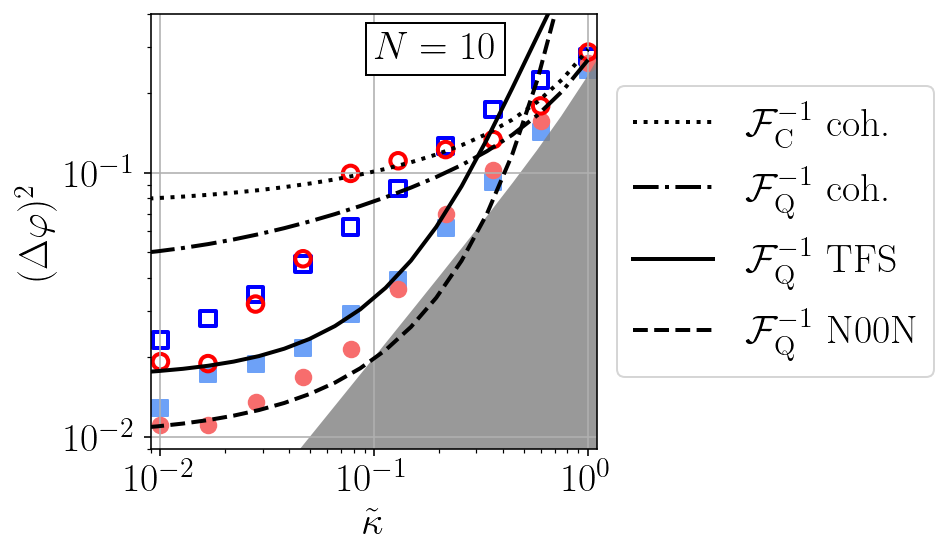

In [6]:
# We plot the figure

plt.rcParams["figure.figsize"] = [4, 4]
fig, ax = plt.subplots(1, 1)
marker_size = 60
ax.grid()
fs = 20

for kappa in kappa_list:

    # Emitters, coherent initial states
    with open('cost_p_adpd_emitters_coherent_asaf_N_kappa={:}.p'.format(kappa), 'rb') as fp:
        cost_preparation_list = pickle.load(fp)
    with open('cost_m_adpd_emitters_coherent_asaf_N_kappa={:}.p'.format(kappa), 'rb') as fp:
        cost_measurement_list = pickle.load(fp)
    ax.scatter(kappa, -1/cost_preparation_list[point], marker='s', s=marker_size, color=[0.427, 0.631, 0.969])
    ax.scatter(kappa, -1/cost_measurement_list[point], marker='s', s=marker_size, facecolors='none', edgecolors='blue', linewidth=2)

    # Kerr, coherent initial states
    with open('cost_p_adpd_kerr_coherent_unbound_asaf_N_kappa={:}.p'.format(kappa), 'rb') as fp:
        cost_preparation_list = pickle.load(fp)
    with open('cost_m_adpd_kerr_coherent_unbound_asaf_N_kappa={:}.p'.format(kappa), 'rb') as fp:
        cost_measurement_list = pickle.load(fp)
    ax.scatter(kappa, -1/cost_preparation_list[point], s=marker_size, color=[0.969, 0.427, 0.427])
    ax.scatter(kappa, -1/cost_measurement_list[point], s=marker_size, color='red', facecolors='none', edgecolors='red', linewidth=2)

N = N_p_list[point] # Value of N for which we're plotting the data
sql = 1/N # Standard quantum limit
tfs = 1/(N*(N+2)/2) # Twin Fock states scaling
hl = 1/N**2 # Heisenberg limit

# Optimal scalings with photon losses (amplitude damping)
kappa_list_asymptotic = 10**(np.linspace(-2.05, 0.1, 20)) # Loss rate list
eta = np.exp(-kappa_list_asymptotic) # Transmission power for the fictitious interferometer representing photon loss
hl_ad = (1-eta)/(eta*N_p/2)
# Optimal scalings with phase damping
hl_pd = (1-eta**2)/(eta*N_p/2)

ax.plot(kappa_list_coh, 1/np.array(CFI_coh), ':k', linewidth=2, label=r'$\mathcal{F}^{-1}_{\rm C}$ coh.')
ax.plot(kappa_list_coh, 1/np.array(QFI_coh), '-.k', linewidth=2, label=r'$\mathcal{F}^{-1}_{\rm Q}$ coh.')

ax.plot(kappa_list_tfs, 1/np.array(QFI_tf), '-k', linewidth=2, label=r'$\mathcal{F}^{-1}_{\rm Q}$ TFS')
ax.plot(kappa_list_tfs, 1/np.array(QFI_noon), '--k', linewidth=2, label=r'$\mathcal{F}^{-1}_{\rm Q}$ N00N')

ax.set_ylim([9e-3, 0.4])

ax.set_xscale('log')
ax.set_yscale('log')


ax.set_xlabel(r'$\tilde{\kappa}$',fontsize=fs)
ax.set_ylabel(r'$(\Delta\varphi)^2$',fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)

plt.text(1e-1, 2.7e-1, r'$N={:}$'.format(int(N_p/2)), fontsize=fs, bbox=dict(facecolor='white', alpha=1.0))

ax.set_xlim([9e-3, 1.1])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

ax.fill_between(kappa_list_asymptotic, hl_pd, facecolor='grey', alpha=.8)